# Deep-Learning Classification of Play Type in NFL Play-By-Play Data

### Ian Johnson, Derek Phanekham, Travis Siems

## Introduction

The NFL (National Football League) has 32 teams split into two conferences, the AFC and NFC. Each of the 32 teams plays 16 games during the regular season (non-playoff season) every year. Due to the considerable viewership of American football, as well as the pervasiveness of fantasy football, considerable data about the game is collected. During the 2015-2016 season, information about every play from each game that occurred was logged. All of that data was consolidated into a single data set which is analyzed throughout this report.

In this report, we will attempt to classify the type of a play, given the game situation before the play began. 

### The Classification Task

We will attempt to classify plays based on play type using information about the state of the game prior to the start of the play. This is expected to be an exceptionally difficult classification task, due to the amount of noise in the dataset (specifically, the decision to run vs pass the ball is often a seemingly random one). A successful classifier would have huge value to defensive coordinators, who could call plays based on the expected offensive playcall. Because it may be very difficult to identify what play will be called, it is relevant to provide a probability of a given playcall in a situation. For example, it would be useful to provide the probability of a 4th down conversion attempt, even if the overall prediction is that a punt occurs. 

### Data Preparation

In order to prepare the data for classification, a number of variables from the original dataset will be removed, as they measure the result of the play, not the state of the game prior to the start of the play. The dataset being included in this report has had previous cleaning and preprocessing performed in our previous report.

In [18]:
#For final version of report, remove warnings for aesthetics.
import warnings
warnings.filterwarnings('ignore')

#Libraries used for data analysis
import pandas as pd
import numpy as np
from sklearn import preprocessing

df = pd.read_csv('data/cleaned.csv') # read in the csv file



colsToInclude = [ 'Drive', 'qtr', 'down',
                 'TimeSecs', 'yrdline100','ydstogo','ydsnet',
                 'GoalToGo','posteam','DefensiveTeam',
                 'PosTeamScore','ScoreDiff', 'PlayType']

df = df[colsToInclude]
df = df[[p not in ["Sack", "No Play", "QB Kneel", "Spike"] for p in df.PlayType]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38600 entries, 0 to 42875
Data columns (total 13 columns):
Drive            38600 non-null int64
qtr              38600 non-null int64
down             38600 non-null int64
TimeSecs         38600 non-null float64
yrdline100       38600 non-null float64
ydstogo          38600 non-null float64
ydsnet           38600 non-null float64
GoalToGo         38600 non-null int64
posteam          38600 non-null object
DefensiveTeam    38600 non-null object
PosTeamScore     38600 non-null float64
ScoreDiff        38600 non-null float64
PlayType         38600 non-null object
dtypes: float64(6), int64(4), object(3)
memory usage: 4.1+ MB


#### Neural Network Embeddings

We will use neural network embeddings from TensorFlow for the posteam and DefensiveTeam. However, we will be building these embeddings manually using one-hot encoding and additional fully-connected layers in each of the deep architectures. The following Python function was used for one-hot encoding, and was adapted from the website referenced in the code.

In [19]:
from sklearn.feature_extraction import DictVectorizer

#Simple function for 1 hot encoding
def encode_onehot(df, cols):
    """
    One-hot encoding is applied to columns specified in a pandas DataFrame.
    
    Modified from: https://gist.github.com/kljensen/5452382
    
    Details:
    
    http://en.wikipedia.org/wiki/One-hot
    http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
    
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    vec = DictVectorizer()
    
    vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict(outtype='records')).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = df.index
    
    df = df.drop(cols, axis=1)
    df = df.join(vec_data)
    return df

df = encode_onehot(df, cols=['posteam', 'DefensiveTeam'])

The following are descriptions of the remaining data columns in the play-by-play dataset. Note that the one-hot encoded columns do not follow the structure listed below, but for the sake of readability they are presented as if they were not one-hot encoded.

* **GameID** (*nominal*): A unique integer which identifies each game played 
* **Drive** (*ordinal*): The number of the drive during a game when the play occurred (indexed at one, so the first drive of the game has Drive 1 and the nth drive has Drive n)
* **qtr** (*interval*): The quarter of the game when the play occurred
* **down** (*interval*): The down when the play occurred (1st, 2nd, 3rd, or 4th)
* **TimeSecs** (*interval*): The remaining game time, in seconds, when the play began
* **yrdline100** (*ratio*): The absolute yard-line on the field where the play started (from 0 to 100, where 0 is the defensive end zone and 100 is the offensive end zone of the team with the ball)
* **ydstogo** (*ratio*): The number of yards from the line of scrimmage to the first-down line
* **ydsnet** (*ratio*): The number of yards from the beginning of the drive to the current line of scrimmage
* **GoalToGo** (*nominal*): A binary attribute whose value is 1 if there is no first down line (the end-zone is the first down line) or 0 if there is a normal first down line
* **posteam** (*nominal*): A 2-or-3 character code representing the team on offense
* **PosTeamScore** (*ratio*): The score of the team with possesion of the ball
* **DefensiveTeam** (*nominal*): A 2-or-3 character code representing the team on defense
* **ScoreDiff**: (*ratio*) The difference in score between the offensive and defensive at the time of the play.
* **PlayType**: (*nominal*) An attribute that identifies the type of play (i.e. Kickoff, Run, Pass, Sack, etc)

### Performance Metrics

The value of a classifier will be evaulated using the following cost matrix. Costs in the matrix which are set to 1 represent play predictions that would never actually occur in the context of a football game. For example, if we predicted a pass play and a kickoff occurs, then the classifier has a significant flaw. 

Bolded weights represent actual mispredictions that could occur.

|                | Actual Play | Pass | Run | Kickoff |     Punt    | Extra Point | Field Goal | Onside Kick |
|----------------|-------------|------|-----|---------|-------------|------------|-------------|-------------|
| Predicted Play |             |      |     |         |             |            |             | |
| Pass           |             | 0    | **0.1** | 1       | **0.15** | **0.15**        | **0.1**         | 1           |  
| Run            |             | **0.1**  | 0   | 1       | **0.15** | **0.15**        | **0.1**         | 1           | 
| Kickoff        |             | 1    | 1   | 0     |  1  | 1           | 1          | **0.75**       |
| Punt           |             | **0.25**    | **0.25**   | 1   | 0 |1       |  **0.15**           | 1           |
| Extra Point    |             | **0.4**  | **0.4** | 1       | 1 | 0           | 1          | 1           |
| Field Goal     |             | **0.4** | **0.4** | 1       | **0.1** | 1           | 0          | 1           |
| Onside Kick    |             | 1    | 1   | **0.25**    |  1 |1           | 1          | 0           |


This performance metric is the best for this classification problem because the actual potential cost of an incorrect play prediction varies significantly based on the nature of the misclassification. In an actual football game, it would be very costly to predict an extra point and have the opposing team run a pass play. This means that they ran a fake extra point and went for a two-point conversion. However, if a pass play is predicted and a run play occurs, the cost of the error is minimal because the defensive strategy for defending against run and pass plays.

Because the goal of this classification is to help inform defensive play-calling, a cost matrix is helpful because it allows a defensive coordinator to set his own costs to produce his own classifier, without any knowledge of the actualy computation that occurs.

### Cross Validation Methodology

We use a sequential k-fold partition of the data because this mirrors how data will be collected and analyzed. For our use, we assume that it is okay to use data in the “future” to predict data “now” because it can represent data from a previous football season. For example, if we use the first 90% of data for training and the remaining 10% of data for testing, that would simulate using most of the current season's data to predict plays towards the end of this season. If we use the first 50% and last 40% of data for training and the remaining 10% for testing, this would simulate using 40% of the previous season's data and the first 50% of this season's data to predict plays happening around the middle of the current season. 

In [20]:
from sklearn.model_selection import KFold

#Using a 10-fold sequential split.
#Note that this cv object is unused, but is here for reference
cv = KFold(n_splits=10)

y,levels = pd.factorize(df.PlayType.values)
X = df.drop('PlayType', 1).values.astype(np.float32)


num_classes = len(levels)

## Modeling

Before we build any models, we define a cost function in Python below, which is used to test all of our forthcoming models. It computes the item-wise product of a confusion matrix and our cost matrix, and returns the sum of all of the elements in the resulting matrix. We also define a function to calculate area under roc curve for a multiclass classification problem.

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc,make_scorer
from scipy import interp

import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

cost_mat =     [[0  ,.1  , 1   , .15 , 0.15, .1 , 1   ],
                [.1 , 0  , 1   , 0.15, 0.15, 0.1, 1   ],
                [1  , 1  , 0   , 1   , 1   , 1  , 0.75],
                [.25,0.25, 1   , 0   , 1   ,0.15,  1  ],
                [0.4, 0.4, 1   , 1   , 0   , 1  ,  1  ],
                [0.4, 0.4, 1   , 0.1 , 1   , 0  ,  1  ],
                [1  , 1  , 0.25, 1   , 1   , 1  ,  0  ]]

def cost(Y, yhat):
    return np.sum(np.multiply(confusion_matrix(Y,yhat), cost_mat))

def auc_of_roc(Y,yhat):
    #classes = ['Pass', 'Run', 'Kickoff', 'Punt', 'Extra Point', 'Field Goal', 'Onside Kick']
    classes = range(0,7)
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    for c in classes:
        tempY = [x==c for x in Y]
        tempYhat = [x==c for x in yhat]
        
        fpr, tpr, thresholds = roc_curve(tempY, tempYhat)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

        roc_auc = auc(fpr, tpr)

    mean_tpr /= len(classes)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    return mean_auc

#For use in the final deployment section
auc_roc_scorer = make_scorer(auc_of_roc)
scorer = make_scorer(cost)

### Some Setup Code for TensorFlow

#### Imports

In [5]:
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib import layers

#Suppress all non-error warnings
tf.logging.set_verbosity(tf.logging.ERROR)

#### Calculating Costs for a Model

The following code performs cross validation on a model with a given step count and learning rate. This will be used as part of the grid search, as well as for evaluating the final classifier after the gridsearch is complete.

In [6]:
def get_scores_for_model(model_fn, X, y, steps=1000, learning_rate=0.05, num_splits = 10):

    auc = []
    costs = []
    
    for train_index, test_index in KFold(n_splits=num_splits).split(X, y):
        classifier = learn.TensorFlowEstimator(model_fn=model_fn, 
                                               n_classes=7, batch_size=1000,
                                               steps=steps, learning_rate=learning_rate)
        classifier.fit(X[train_index], y[train_index])
        yhat = classifier.predict(X[test_index])

        costs.append(cost(y[test_index], yhat))
        auc.append(auc_of_roc(y[test_index], yhat))

    return costs, auc

#### Grid Search

Because we're performing a grid search on a TensorFlow estimator, we use our own grid search function, instead of the one provided in sklearn, for the sake of simplicity. Our grid search will search for optimal values of *steps* and *learning_rate*. During the grid search, a subsample of 5000 items will be used, and only 3 folds of cross validation will occur. This is done to decrease computation time, which is otherwise many hours per grid search.

Note that the grid search function itself is not parallelized. This is because the underlying TensorFlow modelling is all parallelized, so maximal CPU usage is already being achieved.

In [7]:
def grid_search(model_fn, steps_list, learning_rate_list):
    
    costs = []
    
    for steps in steps_list:
        
        step_costs = []
        
        for rate in learning_rate_list:
            
            step_costs.append(np.mean(get_scores_for_model(model_fn, X[0:5000, :], y[0:5000], steps, rate, 3)[0]))
            print(step_costs)
            print(costs)
        
        costs.append(step_costs)
        
    min_idx = np.argmin(costs)
    
    return costs, steps_list[min_idx//len(costs[0])], learning_rate_list[min_idx%len(costs[0])]

In [8]:
import seaborn as sns

def grid_search_heatmap(costs, steps, rates):
    
    ax = sns.heatmap(np.array(costs))
    ax.set(xlabel='Learning Rate', ylabel='Step Count')
    ax.set_xticklabels(rates[::-1])
    ax.set_yticklabels(steps[::-1])
    ax.set_title("Grid Search Heatmap")

### First Deep Learning Architecture

The first deep learning architecture will be adapted from a model designed by PayPal that is used for anomaly detection. Because the vast majority of football plays are either runs or passes, and there are only a few anomalous plays, like onside kicks, etc., it stands to reason that an anomaly detection architecture would perform well for this classification task.

The architecture is quite simple: it consists of a set of 6 fully connected layers of 700 neurons, followed by a hyperbolic tangent activation function and then a single fully connected layer for output. We will adapt this model slightly to allow for the embedding of the team attributes. We will split the data into embedding and non-embedding data, run each subset of data through 6 fully connected layers of 700 neurons, and then combine their output as the input into a single final layer, used for classification. A simple drawing of the architecture is shown below.

<img src="NetworkDrawings/network1.png">

<a href="http://university.h2o.ai/cds-lp/cds02.html?mkt_tok=3RkMMJWWfF9wsRonvanAZKXonjHpfsX56%2BkqUaG0lMI%2F0ER3fOvrPUfGjI4ATsBlI%2BSLDwEYGJlv6SgFTLTBMbBrwrgKXBk%3D">
The original talk about this architecture can be found here.
</a>

##### Defining the Model

In [9]:
def deep_model_1(X, y):

    #Embeddings layer
    teamembeddings = layers.stack(X[:,11:75], layers.fully_connected, [700 for _ in range(6)])
    teamembeddings = tf.nn.tanh(teamembeddings)
    
    #Non-embeddings features
    otherfeatures = X[:,0:10]
    otherfeatures = layers.stack(otherfeatures, layers.fully_connected, [700 for _ in range(6)])
    
    tensors = tf.concat(1, [teamembeddings, otherfeatures])
    tensors = tf.nn.tanh(tensors)
    
    pred,loss = learn.models.logistic_regression(tensors, y)

    return pred, loss

##### Grid Searching on the Model

A grid search is performed on the model to find the approximately optimal step count and learning rate for the TensorFlowEstimator. Note that this particular grid search takes about 14 hours to run, so it should not be re-run.

In [48]:
costs, optimal_steps, optimal_rate = grid_search(deep_model_1, [250,500,1000,1500,2000], [.05, .01, .005, .001, .0005])
print((optimal_steps, optimal_rate))

(500, 0.01)


Although the grid search returned the optimal step count and rate, it is meaningful to visualize the grid that was generated, to get an idea for how much better these particular hyperparameters are than the other possible combinations in the grid.

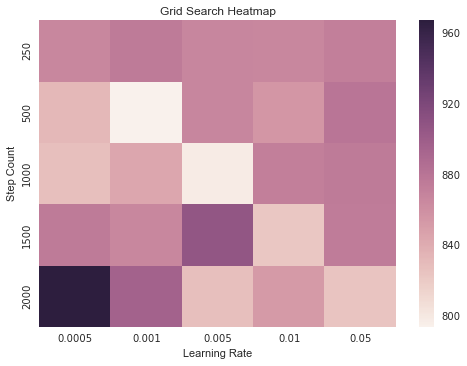

In [63]:
grid_search_heatmap(costs, [250,500,1000,1500,2000], [.05, .01, .005, .001, .0005])

The above grid search shows that, while there is no obvious pattern with respect to the performance, it seems that the major diagonal generally has the lowest costs. Interestingly, the lower-left tile has a significantly higher score than all of the others. This is likely due to overlearning, as it comes from a section in the grid with the highest possible step count.

The optimal parameter pair, of 500 steps and a learning rate of .001, is only marginally better than the second-best option, which falls at 1000 steps and a learning rate of .005.

##### Calculating Costs and Area under ROC Curve Scores for the Model

With the optimal step count and learning rate, the costs of the model built with the given step count and rate are computed.

In [12]:
costs_model_1, auc_roc_model_1 = get_scores_for_model(deep_model_1, X, y, optimal_steps, optimal_rate)

print(costs_model_1)
print(auc_roc_model_1)

[1843.45, 2005.0, 2017.0, 1971.05, 2069.25, 2021.75, 1942.8499999999999, 2048.25, 2022.0, 2042.0999999999999]
[0.51052936522990444, 0.50011988848000888, 0.49999999999999994, 0.50082942390789931, 0.49999999999999994, 0.49999999999999994, 0.50244062722123584, 0.49999999999999994, 0.50046048738783466, 0.49987541305436189]


The costs and auc scores computed above are hard-coded below for later use, so that they don't need to be computed again.

In [1]:
costs_model_1 = [1843.45, 2005.0, 2017.0, 1971.05, 2069.25, 2021.75, 1942.8499999999999, 2048.25, 2022.0, 2042.0999999999999]
auc_roc_model_1 = [0.51052936522990444, 0.50011988848000888, 0.49999999999999994, 0.50082942390789931, 0.49999999999999994, 0.49999999999999994, 0.50244062722123584, 0.49999999999999994, 0.50046048738783466, 0.49987541305436189]

### Second Deep Learning Architecture

The second deep learning architecture will be adapted from a model designed by O'Shea Research that is used for radio modulation recognition. Because the majority of the football data is ordinal numerical data, an architecture that uses similar data for a classification task poses as a candidate model for the football play classification task.

The architecture consists of a set of two convolutional reLu neurons, followed by a dense relu and dense softmax activation function. The result is a single fully connected layer for output. We will adapt this model slightly to allow for the embedding of the team attributes. We will split the data into embedding and non-embedding data, run each subset of data through the convolutional and dense neurons, and then combine their output as the input into a single final layer, used for classification. A simple drawing of the architecture is shown below.

<img src="NetworkDrawings/network2.png">

<a href="https://oshearesearch.com/index.php/tag/deep-learning/">
The original discussion about this architecture can be found here.
</a>

#### Defining the Model

In [ ]:
%%time

def deep_model_2(X, y):
    
    
    #Embeddings layer
    teamembeddings = layers.stack(X[:,11:75], layers.fully_connected, [200,1,3], activation_fn=tf.nn.relu)
    teamembeddings = layers.stack(teamembeddings, layers.fully_connected, [50,2,3], activation_fn=tf.nn.relu)
    
    #Non-embeddings features
    otherfeatures = X[:,0:10]
    otherfeatures = layers.stack(otherfeatures, layers.fully_connected, [50,1,3], activation_fn=tf.nn.relu)
    otherfeatures = layers.stack(otherfeatures, layers.fully_connected, [12,2,3], activation_fn=tf.nn.relu)

    #combine the team and play data
    tensors = tf.concat(1, [teamembeddings, otherfeatures])
    
    tensors = layers.stack(tensors, layers.fully_connected, [100], activation_fn=tf.nn.relu)
    tensors = layers.stack(tensors, layers.fully_connected, [7], activation_fn=tf.nn.softmax)
    

    """  # This section is doing all layers before combining team and play data
    #Embeddings layer
    teamembeddings = layers.stack(X[:,11:75], layers.fully_connected, [200,1,3], activation_fn=tf.nn.relu)
    teamembeddings = layers.stack(teamembeddings, layers.fully_connected, [50,2,3], activation_fn=tf.nn.relu)

    teamembeddings = layers.stack(teamembeddings, layers.fully_connected, [100], activation_fn=tf.nn.relu)
    teamembeddings = layers.stack(teamembeddings, layers.fully_connected, [7], activation_fn=tf.nn.softmax)
    
    #Non-embeddings features
    otherfeatures = X[:,0:10]

    otherfeatures = layers.stack(otherfeatures, layers.fully_connected, [50,1,3], activation_fn=tf.nn.relu)
    otherfeatures = layers.stack(otherfeatures, layers.fully_connected, [12,2,3], activation_fn=tf.nn.relu)

    otherfeatures = layers.stack(otherfeatures, layers.fully_connected, [100], activation_fn=tf.nn.relu)
    otherfeatures = layers.stack(otherfeatures, layers.fully_connected, [7], activation_fn=tf.nn.softmax)

    #combine the team and play data
    tensors = tf.concat(1, [teamembeddings, otherfeatures])
    """

    
    
    pred, loss = learn.models.logistic_regression(tensors, y)
    
    return pred, loss

##### Grid Searching on the Model

A grid search is performed on the model to find the approximately optimal step count and learning rate for the TensorFlowEstimator.

In [64]:
costs, optimal_steps, optimal_rate = grid_search(deep_model_2, [250,500,1000,1500,2000], [.05, .01, .005, .001, .0005])
print((optimal_steps, optimal_rate))

(1500, 0.005)


Although the grid search, once again, gave us the optimal step count and rate, it is worthwhile to visualize the grid that was generated, to get an idea for how much better these particular hyperparameters are than the other possible combinations in the grid.

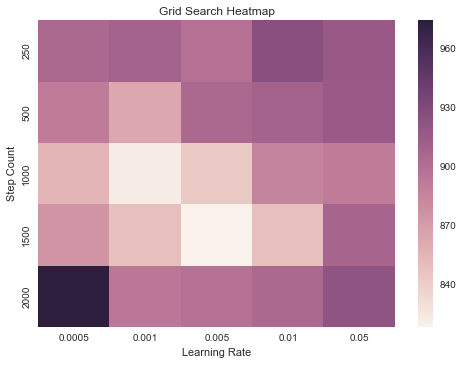

In [63]:
grid_search_heatmap(costs, [250,500,1000,1500,2000], [.05, .01, .005, .001, .0005])

This heatmap shows a stronger pattern than the map for model 1. It shows the optimal to be centered around 1500 steps and a learning rate of 0.005, with somewhat constant cost increase as the two parameters grow greater or smaller than thoses values.

There is, however, still an abnormality with very high step count and very low learning rate, once again presumably due to overtraining. This may be something that could be fixed by changing the batch size for the tensorflow estimator function, but this grid search already took about 10 hours to run, so adding a 3rd parameter is not feasible with the compute power available to us.

##### Calculating Costs and Area under ROC Curve Scores for the Model

With the optimal step count and learning rate, the costs of the model built with the given step count and rate are computed.

In [69]:
costs_model_2, auc_roc_model_2 = get_scores_for_model(deep_model_2, X, y, optimal_steps, optimal_rate)

print(costs_model_2)
print(auc_roc_model_2)

[2042.75, 2007.5, 2017.0, 1978.0, 2069.25, 2021.75, 1974.0, 2048.25, 2027.0, 2041.25]
[0.5085592, 0.4820538, 0.48592543, 0.48381174, 0.47515301, 0.475777, 0.47903248, 0.48797259, 0.47638676, 0.4891856]


The costs and auc scores computed above are hard-coded below for later use, so that they don't need to be computed again.

In [2]:
costs_model_2 = [2042.75, 2007.5, 2017.0, 1978.0, 2069.25, 2021.75, 1974.0, 2048.25, 2027.0, 2041.25]
auc_roc_model_2 = [ 0.5085592, 0.4820538, 0.48592543, 0.48381174, 0.47515301, 0.475777, 0.47903248, 0.48797259, 0.47638676, 0.4891856]

### Third Deep Learning Architecture

EXPLAIN IT!

In [9]:
def deep_model_3(X, y):

    #Embeddings layer
    teamembeddings = layers.stack(X[:,11:75], layers.fully_connected, [20,4])
    #teamembeddings = tf.nn.relu(teamembeddings)
    
    #Non-embeddings features
    otherfeatures = X[:,0:10]

    #Concatenate the embeddings with the non-embeddings
    tensors = tf.concat(1, [teamembeddings, otherfeatures])
    
    #[500,200,100,500][1000,1000,1000,500,200,1000]
    tensors = layers.stack(tensors, layers.fully_connected, [1000,1000,1000,500,200,1000])
    
    #Relu activation function
    tensors = tf.nn.relu(tensors)

    pred, loss = learn.models.logistic_regression(tensors, y)
    
    return pred, loss

##### Grid Searching on the Model

A grid search is performed on the model to find the approximately optimal step count and learning rate for the TensorFlowEstimator.

In [10]:
costs, optimal_steps, optimal_rate = grid_search(deep_model_3, [250,500,1000,1500,2000], [.05, .01, .005, .001, .0005])
print((optimal_steps, optimal_rate))

(2000, 0.005)


Although the grid search returned the optimal step count and rate, it is meaningful to visualize the grid that was generated, to get an idea for how much better these particular hyperparameters are than the other possible combinations in the grid.

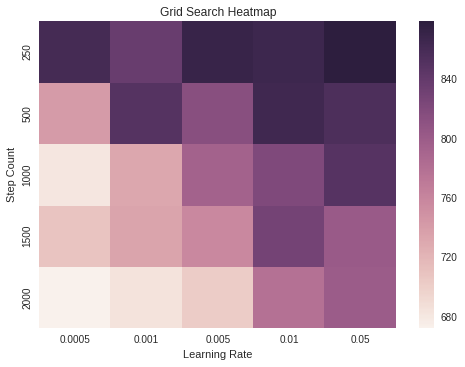

In [12]:
grid_search_heatmap(costs, [250,500,1000,1500,2000], [.05, .01, .005, .001, .0005])

The grid search for model 3, interestingly, shows a significant trend toward lower costs in the lower-left part of the map (higher step count and lower learning rate). This stands to reason, and aligns much more with what is expected than the unruly heatmap that was generated by the model 1 grid search.

This grid search showed 2000 steps with a learning rate of 0.0005 as an optimal. This optimality only slightly outperforms the same learning rate with only 1000 steps, but significantly outperforms every hyper-parameter pair above the major diagonal of the heatmap. 

##### Calculating Costs and Area under ROC Curve Scores for the Model

With the optimal step count and learning rate, the costs of the model built with the given step count and rate are computed.

In [13]:
costs_model_3, auc_roc_model_3 = get_scores_for_model(deep_model_3, X, y, optimal_steps, optimal_rate)

print(costs_model_3)
print(auc_roc_model_3)

[1750.0, 1722.85, 1709.0, 1710.75, 1716.25, 1742.0, 1650.0, 1714.0, 1699.5, 1684.5]
[0.62998537, 0.61758681, 0.61135905, 0.61209804, 0.6146912, 0.62633358, 0.5845431, 0.61362667, 0.60702243, 0.60023413]


The costs and auc scores computed above are hard-coded below for later use, so that they don't need to be computed again.

In [3]:
costs_model_3 = [ 1750.0 ,  1722.85,  1709.0,  1710.75, 1716.25,  1742.0,  1650.0 ,  1714.0, 1699.50,  1684.50]
auc_roc_model_3 = [0.62998537,  0.61758681,  0.61135905,  0.61209804,  0.6146912 , 0.62633358,  0.5845431 ,  0.61362667,  0.60702243,  0.60023413]

### Architecture Comparison

The following getDifference function is used to create a tuple of the range of possible differences of mean for two sets of scores (cost or auc_roc), with 95% confidence. We use the second of the two confidence interval tests proposed in the ICA3 reversed assignment, because the datasets cannot be assumed to be independent, so the binomial approximation to the normal distribution does not hold.

In [4]:
def getDifference(cost1,cost2,z_val=2.26,size=10):
    cost1 = np.asarray(cost1)
    cost2 = np.asarray(cost2)
    diff12 = cost1 - cost2
    sigma12 = np.sqrt(np.sum(diff12*diff12) * 1/(size-1))
    d12 = (np.mean(diff12) + 1/(np.sqrt(size)) * z_val * sigma12, np.mean(diff12) - 1/(np.sqrt(size)) * z_val * sigma12)
    return d12

#### Cost Difference

The getDifference function is now used to create confidence intervals for the cost differences of the 3 possible pairs of two architectures created from the set of 3 architectures.

In [7]:
d_one_two = np.array(getDifference(costs_model_1, costs_model_2))
d_one_three = np.array(getDifference(costs_model_1, costs_model_3))
d_two_three = np.array(getDifference(costs_model_2, costs_model_3))

print("Average Model 1 vs Model 2 Difference:", d_one_two)
print("Average Model 1 vs Model 3 Difference:", d_one_three)
print("Average Model 2 vs Model 3 Difference:", d_two_three)

Average Model 1 vs Model 2 Difference: [ 23.69702196 -72.50702196]
Average Model 1 vs Model 3 Difference: [ 512.26558725   64.50441275]
Average Model 2 vs Model 3 Difference: [ 549.47453987   76.10546013]


The above 3 confidence intervals show that the first two architectures performed similarly, as the model 1 to model 2 difference confidence interval contains zero. However, the third architecture, which we created specifically because of how poorly the first two architectures performed, did significantly outperform both of the first two models, as zero does not appear in either of the confidence intervals including model 3. Therefore, it can be concluded that, with respect to cost, our "home-grown" model 3 does significantly outperform the other architectures.

#### Area Under Multiclass ROC Curve Difference

The same process is now used for confidence intervals for the auc_roc metric.

In [79]:
d_one_two = np.array(getDifference(auc_roc_model_1, auc_roc_model_2))
d_one_three = np.array(getDifference(auc_roc_model_1, auc_roc_model_3))
d_two_three = np.array(getDifference(auc_roc_model_2, auc_roc_model_3))

print("Average Model 1 vs Model 2 Difference:", d_one_two)
print("Average Model 1 vs Model 3 Difference:", d_one_three)
print("Average Model 2 vs Model 3 Difference:", d_two_three)

Average Model 1 vs Model 2 Difference: [ 0.0309479   0.00313162]
Average Model 1 vs Model 3 Difference: [-0.02675915 -0.19388588]
Average Model 2 vs Model 3 Difference: [-0.03095869 -0.22376586]


The confidence intervals for area under ROC curve provide the same insight as the confidence intervals for the cost function. The first 2 models are statistically similar with 95% confidence, but the third model statistically outperforms both of the first 2, with 95% confidence, because zero does not fall in the ROC difference confidence interval for model 3 vs the other 2 models. 

With the ROC curve score's confirmation, we can confidently declare that architecture 3 is better for this classification task than models 1 and 2. However, in our deployment section, we will address the possibility that even our best deep learning architecture may be outperformed by conventional machine learning algorithms which were explored in Project 2.

## Deployment

Given the performances of the three above deep learning models for classifying NFL play types, we beleive that model 3 would be the best choice, as it, with statistical significance, outperformed both other models with respect to both cost and AUC_ROC score. However, the costs for the models generated, as well as the AUC_ROC scores, seemed to, in general be inferior to the scores from the conventional algorithms. 

In our previous report, we declared random forests to be our preffered model, due to their superior performance, and ease of use / computational inexpense. Therefore, for the purpose of comparison, we will compare the performance of random forests to the performance of our best deep learning architecture.

Note that we (mistakenly) used an incorrect cross-validation strategy for Lab 2, so random forest scores must be re-generated. The code below, to generate the new scores, is adapted from Lab 2 for use with our new cross validation strategy. 

First, we perform some setup that is needed to use the original SKLearn library for classification.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

#Building the class weight map
PlayTypes = df.PlayType.value_counts().index.tolist()
Costs = [sum(x) for x in cost_mat]
y = df.PlayType.values

ClassWeights = dict(zip(PlayTypes, Costs))

Next, we produce cost scores for the random forest classifier.

In [26]:
#Pipeline for cost evaluation
clf = Pipeline([('sca',StandardScaler()),
                ('clf',RandomForestClassifier(class_weight=ClassWeights, n_estimators=250))])

per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=scorer,
                                    n_jobs=-1
                                   )

RFCosts = per_fold_eval_criteria

Finally, we produce AUC_ROC scores for the random forest classifier.

In [28]:
#Pipeline for cost evaluation
clf = Pipeline([('sca',StandardScaler()),
                ('clf',RandomForestClassifier(class_weight=ClassWeights, n_estimators=250))])

per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=auc_roc_scorer,
                                    n_jobs=-1
                                   )

RF_auc = per_fold_eval_criteria

The cost and auc scores for the random forest are saved below so that they don't need to be re-computed.

In [32]:
RFCosts = [  988.05,  1007.9 ,   976.75,   956.75,   971.75,   949.55, 919.  ,   992.5 ,   985.75,   956.  ]
RF_auc = []

In [11]:
auc_diff = getDifference(auc_roc_model_3, RF_auc)
cost_diff = getDifference(costs_model_3, RFCosts)

print("Deep Learning vs Random Forests (Cost):", cost_diff)
print("Deep Learning vs Random Forests (AUC_ROC):", auc_diff)

Deep Learning vs Random Forests (Cost): (1222.894780726243, 161.94521927375706)
Deep Learning vs Random Forests (AUC_ROC): (-0.058833266410790452, -0.42579744358920951)
